## Corrélation rythmes cérébraux - sharp waves ripples - delta - spindle

#### Projet Recherche Iris Dumeur 2018-2019

Il faut que la conversion en fichier txt (via Matlab a été faite)
Je souhaite observer spindle et delta et regarder étudier des SPW-Rs sur d'autres patients


In [1]:
#définition des variables et import
import numpy as np
import matplotlib.pyplot as plt

#contient mes fonctions
from Fast_treatment import * 
from Traitement_fich import*
from Cluster_v1 import *
from Ana_SPW import *

#Variables utiles
time=1800 #en seconde, on peut changer ci-necessaire
chemin ='/Users/iris/Desktop/Projet_Rech/Exemple/EEG_58_Sig/Donnes_signaux/' #change depending the data set

T=[round(i/512,6) for i in range(1,time*512+1)] #contains time 
char_A=chemin+"A'2-A'1_1800s.txt" #plus vraiment utile actuellement
char_B =chemin+"B'2-B'1_1800s.txt" #à changer en fonction des fichiers à étudier
char_O=chemin+"O'9-O'8_1800s.txt" #pour rythmes delta et spindle

### Séries temporelles utilisées

##### Affichage du signal brut
On utilise la fonction trace dans le fichier Traitement_fich.py

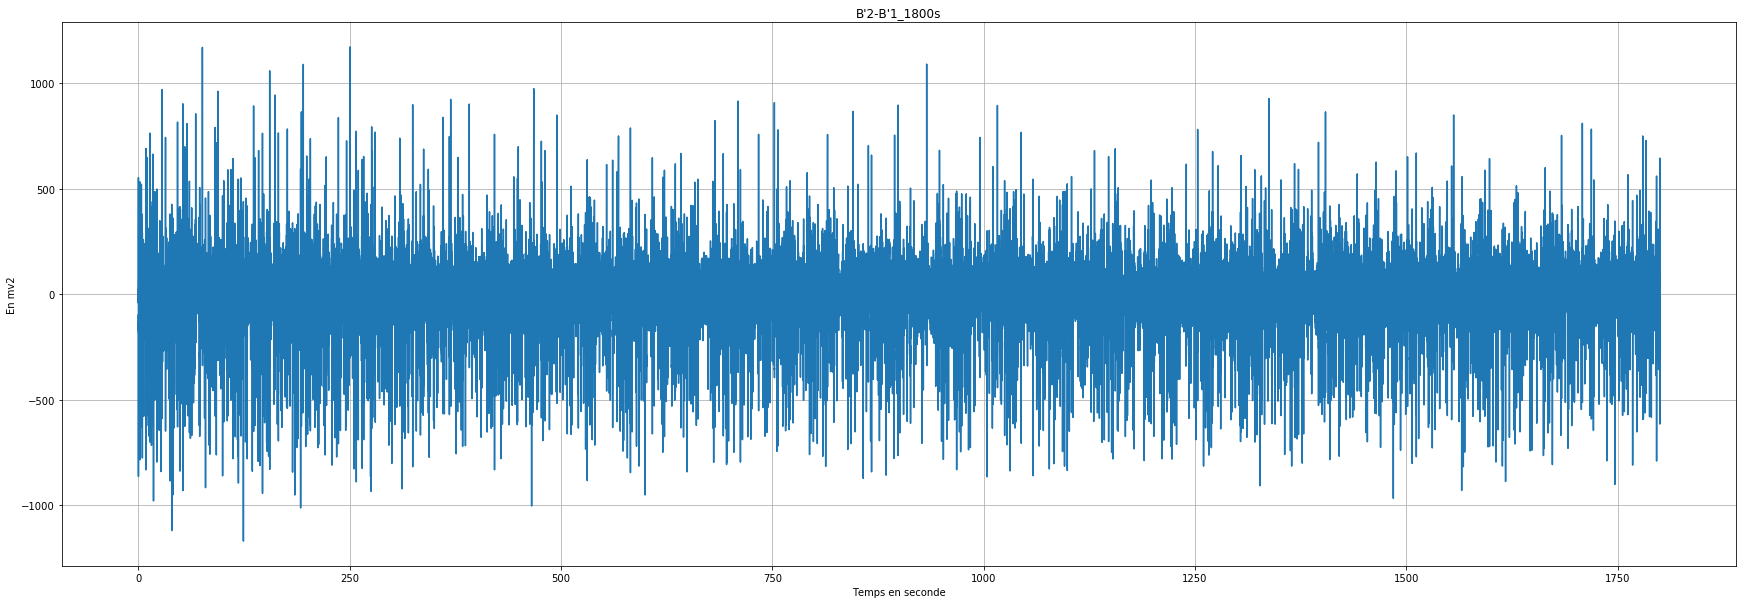

In [2]:
trace(char_B,T)

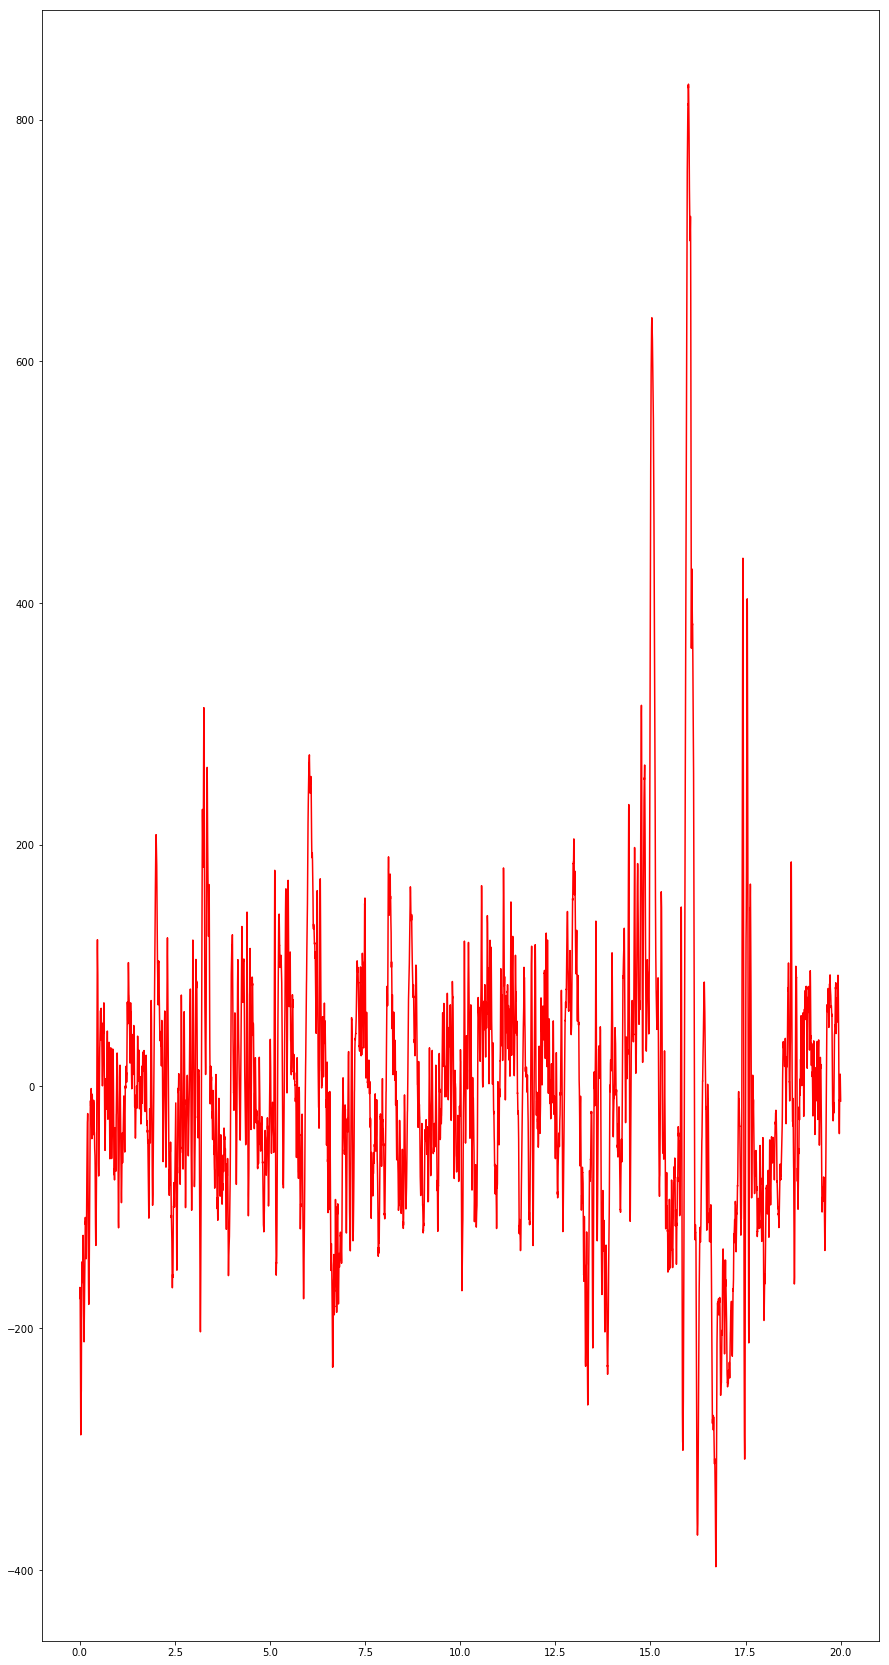

In [3]:
# Filtrage
plot_filtre(char_O,T,opt='delta')

Il s'agit du signal brut. Ce signal sera ensuite filtré. Pour un SPW-Rs : 120-250 Hz pour un rythme delta : 1 - 4Hz. Il s'agit de la fonction filtre

#### Puissance du signal 
Afin d'avoir une lecture plus clair du signal : on n'en garde que l'enveloppe. On utilise on calcule la puissance de ce signal \\
$ Insérer formule $ \\


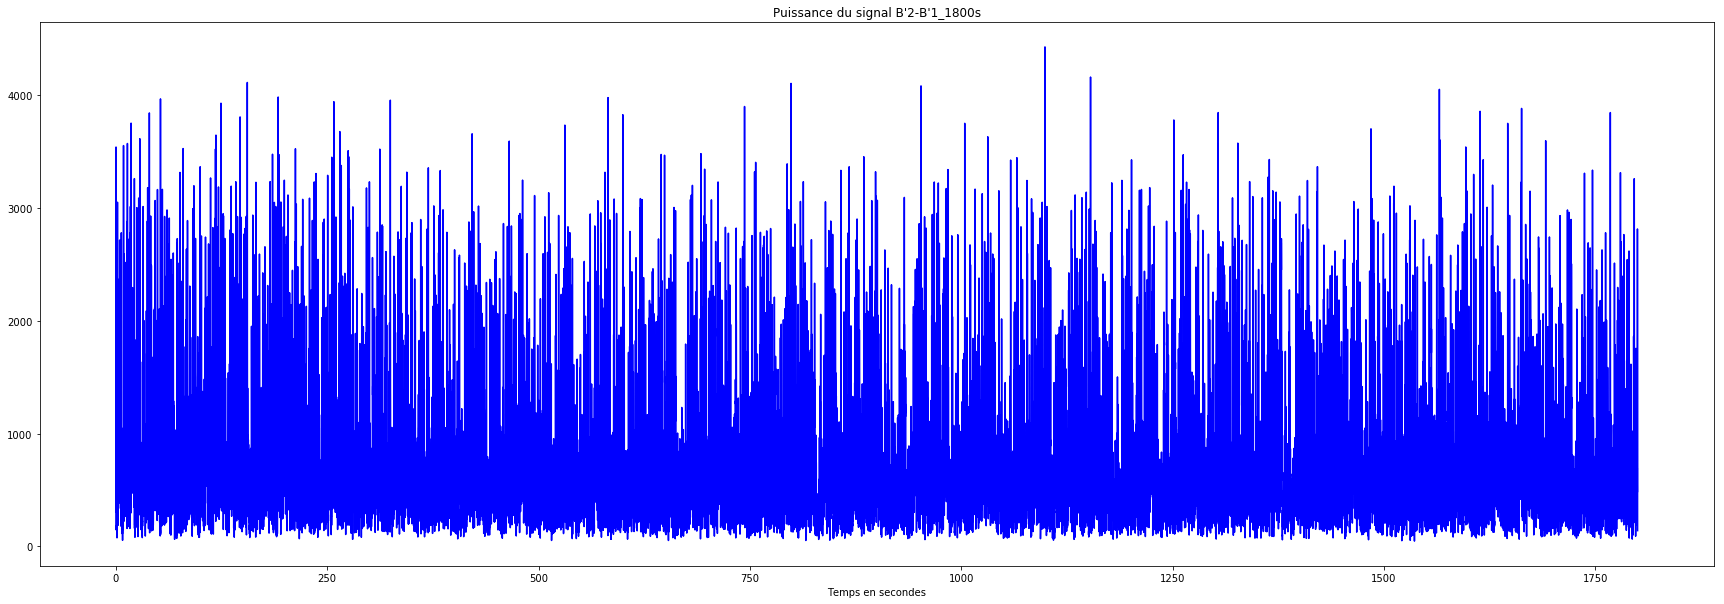

In [4]:
aff_puiss(char_B,T,h=20,opt='ripples') #h indique la taille du pas fait entre chaque calcule de puissance.
#opt indique la taille de l'enveloppe considéré ainsi que la bande de fréquence appliqué au signal. Cela dépend des rythmes étudiés. opt peut être égal à delta

#### Vecteur indicatrice

On cherche ensuite à déterminer les évènements importants. On décide avec un critère simple. Lorsque la puissance dépasse un certain seuil : un SPW est détecté. C'est la fonction detect_pic qui s'en charge. Elle élimine aussi les évènements trop court (< 20 ms) De cette analyse on crée une nouvelle série temporelle appelée par la suite vecteur indicateur. 

##### SPW-Rs

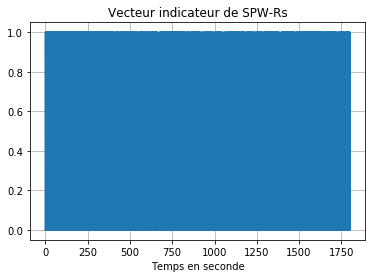

On compte 1829 SPW-Rs


In [5]:
vect,n=vect_detect_pic(char_B,T,opt='ripples',fact=1,max_fact=50,h=1)
plt.figure(1,figsize=(30,10))
plt.plot([i/512 for i in range(len(vect))], vect)
plt.xlabel('Temps en seconde')
plt.title('Vecteur indicateur de SPW-Rs')
plt.show()
print("On compte "+ str(n) + " SPW-Rs")

##### Delta

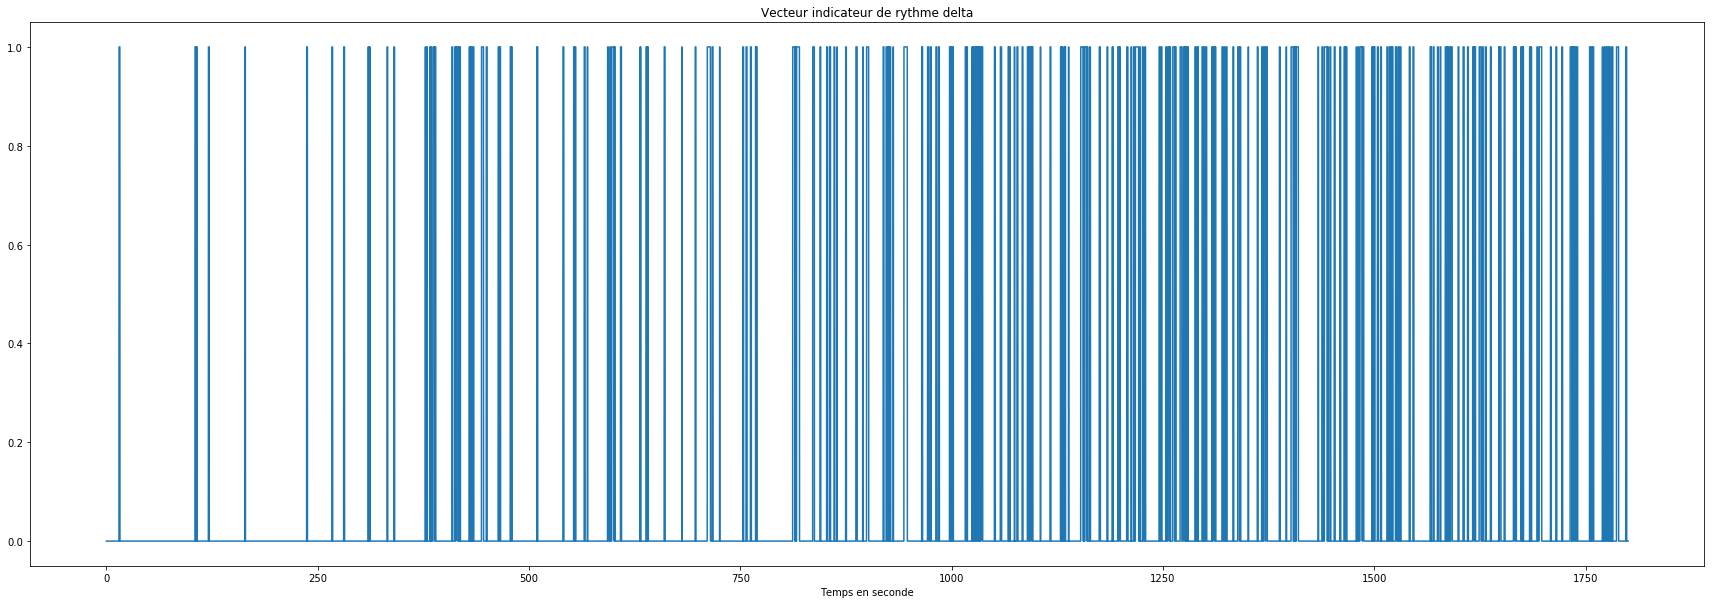

On compte 277 rythmes delta


In [6]:
vect_d,nd=vect_detect_pic(char_O,T,opt='delta',fact=1,max_fact=50,h=1)
plt.figure(2,figsize=(30,10))
plt.plot([i/512 for i in range(len(vect_d))], vect_d)
plt.xlabel('Temps en seconde')
plt.title('Vecteur indicateur de rythme delta')
plt.show()
print("On compte "+ str(nd) + " rythmes delta")

###  Détection de SPW 
On cherche maintenant à détecter des sharp waves ripples. On a initiallement utilisé un critère simple. Cependant cette méthode nous indique plein de pics possibles. On observe alors beaucoup moins de rythmes delta que de SPW-Rs. Il faut donc essayer de trier/classer ces rythmes SPW-Rs.



##### Clustering simple

On se base initiallement avec trois critères : 
- La durée de l'évènement SPW-Rs 
- L'Amplitude en haute fréquence (120-250Hz)
- L'Amplitude en plus basse fréquence (10-80 Hz)

On a pas d'idées du nombre de groupe de SPW-Rs à observer... On utilise une méthode ascendante pour tracer le dendogramme. Ici la méthode de Ward



/Users/iris/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


cophenecy 0.7440271245389293


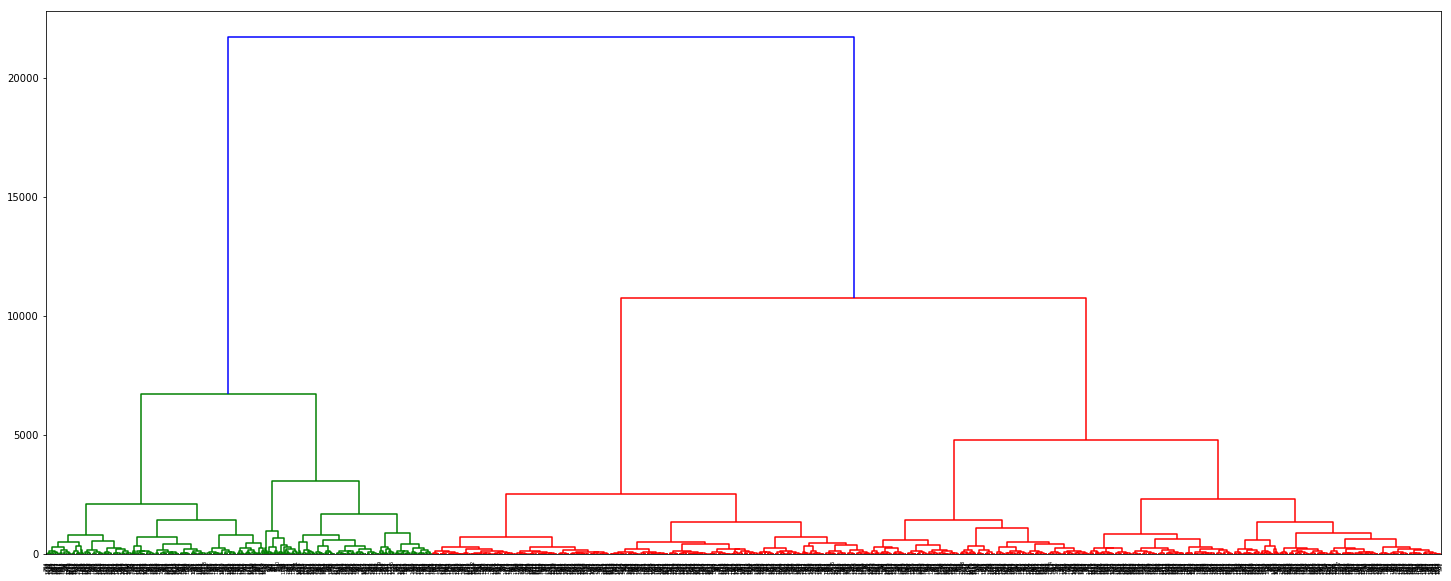

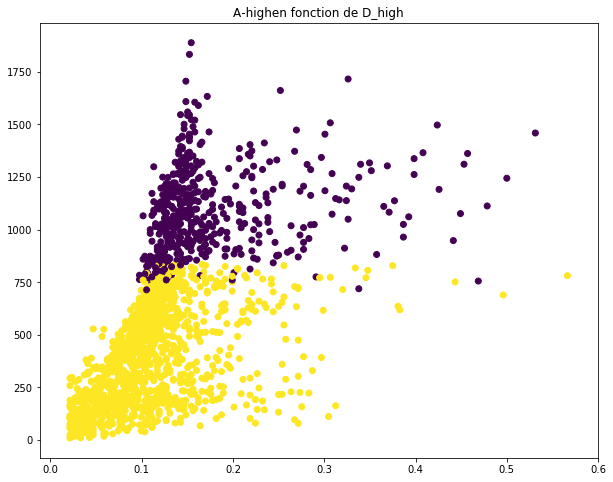

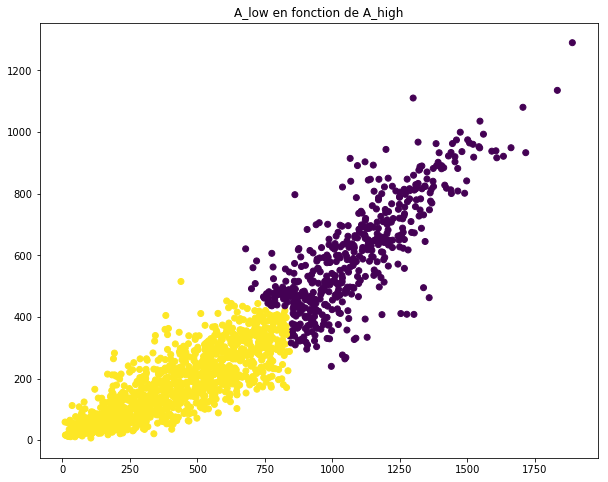

In [7]:
cluster,t_max_pic_high,ind,A_high,A_low,D_high=asc_cluster(char_B,T,'ward',True) #ward average, complete

À priori notre classification est pas bonne puisque les classes ne sont pas assez séparé. 

#### Clustering v2

N'étant pas satisfaite pas cette classification, on cherche maintenant une autre manière de trier ces SPW-Rs. On change les variables utilisés. Au lieu de ne les trier uniquement par avec l'amplitude et la durée de l'évènement, on cherche à étudier la variation du SPW-Rs. On va garder en mémoire à chaque fois que l'on détecte un SPW-Rs les 20ms correspondantes du signal brut. Ensuite on va chercher à garder uniquement des comportements caractéristiques. En reprenant le raisonnement de l'article "Diversity of sharp-wave–ripple LFP signatures reveals differentiated brain-wide dynamical events", nous allons utiliser l'algorithme de growing neural gas (obtenir une centaine de noeuds). A partir du graphe obtenue on en déduira des classes. 
Des growing neural Gas sont disponibles grâce à la bibliothèque neupy. 

##### Growing Neural Gas 

###### Principe de l'algorithme
Il s'agit de créer un réseau de neurones auto organisateur. 
Il se décompose en différentes étapes : 
- On intialise le set A  qui contient deux unité c1 et c2 . Et l'ensemble des arètes C est l'ensemble vide.
- On génère un input (aléatoire ???) selon p(\epsilon).
- Determine le gagnant s1 et le second gagnat s2 (le deuxième noeud le plus proche de notre input)
$s1=arg min _{c\in A} || \epsilon - w_c ||$
- Si une connection entre $s_1$ et $s_2$ n'existe pas encore on la crée, on update C. On on initilalise "l'age" de la connection (refresh the edge) $age_{(s1,s2)} =0 $
- On ajoute le carré de la distance entre l'input signal et le gagnant à l'erreur local variable : $\Delta E _{s1}=|| \epsilon - w_s1 ||^2$
- On adapte le vecteur de référence (gagna= le plus proche), et ses voisins les plus proche 
$\Delta w_{s1}=\epsilon _{b}(\epsilon-w_{s1})$
$\Delta w_i = \epsilon_{n}(\epsilon -w_i)(\forall i \in N_{s1})$
- On incrémente les ages de toutes les arètes provenant de $s_1$ : $age_{(s1,i)}=age_{(s1,i)}+1 (\forall i \in N_{s1})$
- On enlève toutes les arètes avec un age supérieur à a_ma. Si un noeud n'a plus d'arètes : on supprime le noeud
- Si le nombre de nouvel input considéré est un multiple de $\lambda$ : on ajoute un nouveau noeud selon le principe suivant : <br/>
a) on determine le noeud q avec l'erreur cumulé maximal <br/>
b) On détermine parmi les voisins de q le noeud f avec le maximum d'erreur cumulé <br/>
c) On ajoute une nouvelle unité r au réseau : $w_r=(w_q+w_f)/2$ <br/>
d) On insère les arètes  r-f et r-q et on enlève l'ancienne arète f-q <br/>
e) On diminue l'erreur de $\alpha$ pour q et f. $\Delta E_q=-\alpha E_g$ <br/>
f) Et on interpole l'erreur de r à partir de celle de f et q : 
$E_r=(E_f+E_q)/2$
- On dimunue l'erreur de toutes les unités : $\Delta E_c=-\beta E_c (\forall c \in A)$
- Si le critère d'arrêt n'est pas vérifié : retour à l'étape 2 ! 

Afin de s'assurer que la méthode et son implémentation sur python est bien comprise. Testons sur un rapide exemple : 

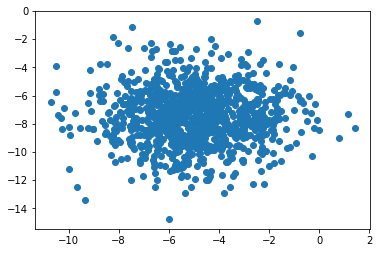

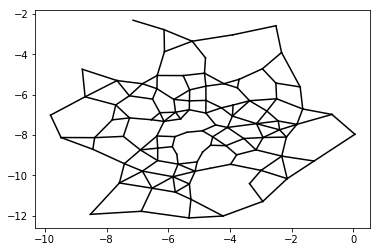

In [3]:
from sklearn.datasets import make_blobs, make_moons
from neupy import algorithms
from ClusterGNG import * 
import io
import sys

x,y = make_blobs(n_samples=1000, n_features=2,centers=1,cluster_std=2)
plt.scatter(*x.T,marker='o')
plt.show()
text_trap = io.StringIO()
sys.stdout = text_trap
neural_gas = algorithms.competitive.growing_neural_gas.GrowingNeuralGas(n_inputs=2,shuffle_data=True,verbose=True, max_edge_age=10, n_iter_before_neuron_added=50,max_nodes=100)

neural_gas.train(x,epochs=100)
# now restore stdout function
sys.stdout = sys.__stdout__
plt.figure()

draw_graph(neural_gas.graph)
plt.show()




#### Choix du type de vecteur input

En se basant sur le même acticle que précèdemment, nous calculons les features intéressant pour la classification des sharp waves ripples 

- L'amplitude du sharp waves ripples
- La puissance du sharp waves ripples
- Le nombre d'oscillation au dessus de 50% de l'amplitude max du sharp waves ripples
- La fréquence du pic détecté



/Users/iris/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


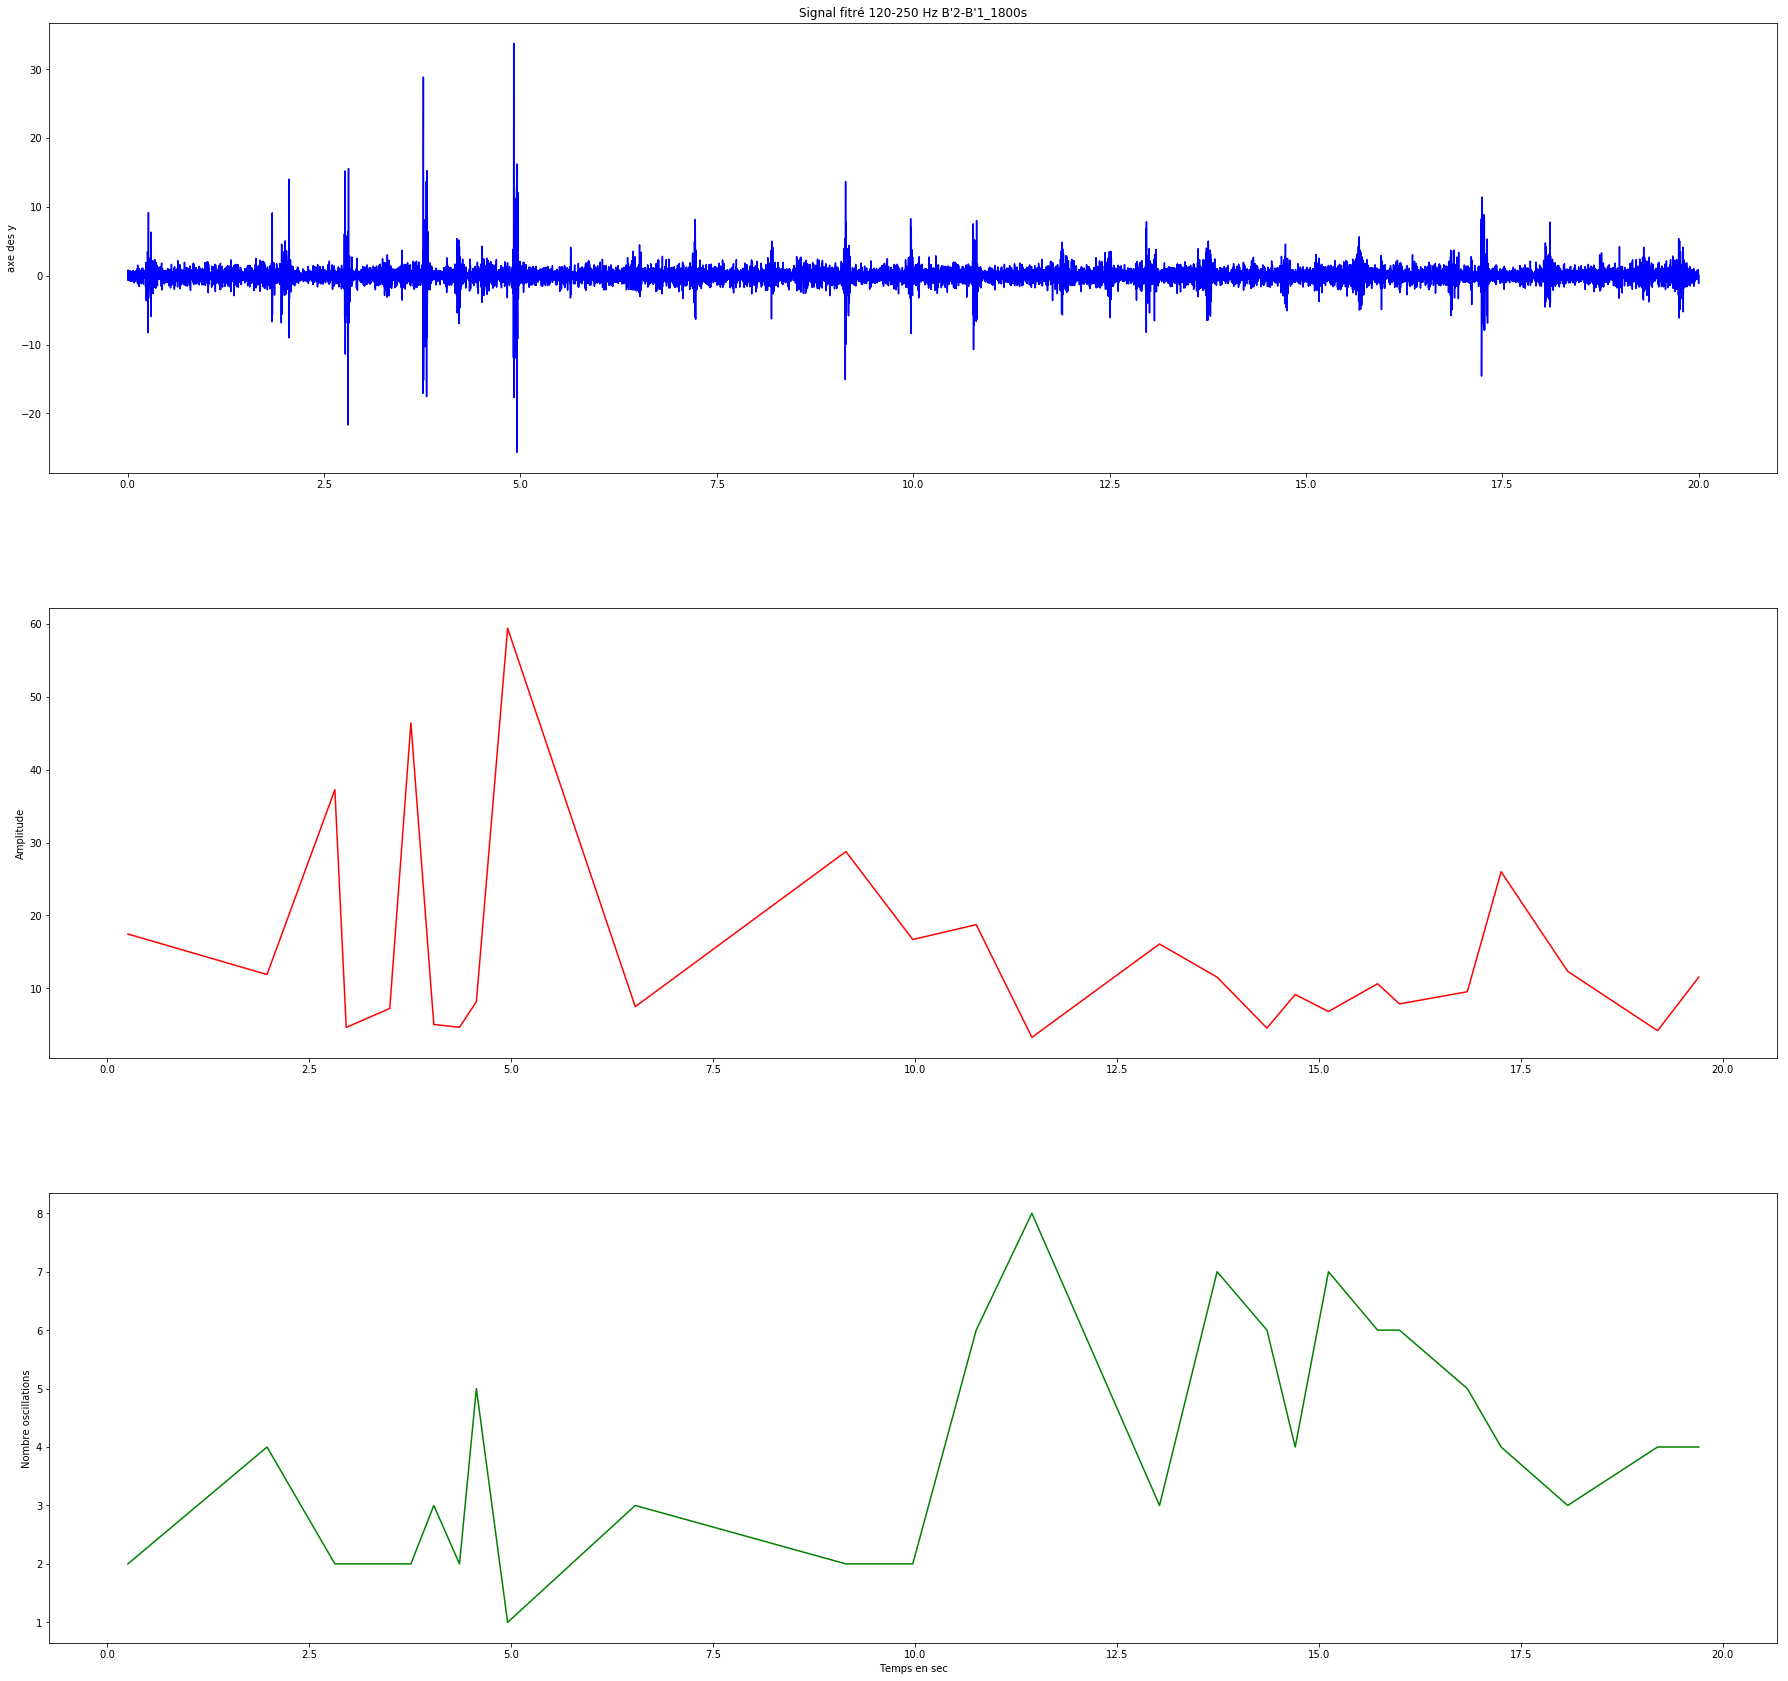

In [6]:
from extract_features import *
time=20
T=[round(i/512,6) for i in range(1,time*512+1)]
chemin ='/Users/iris/Desktop/Projet_Rech/Exemple/EEG_58_Sig/Donnes_signaux/'
char_A=chemin+"A'2-A'1_300s.txt" #a changer en fonction de la taille de l'extrait considéré
char_B =chemin+"B'2-B'1_1800s.txt"
char_O=chemin+"O'9-O'8_1800s.txt"
plot_crit(char_B,T)

/Users/iris/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


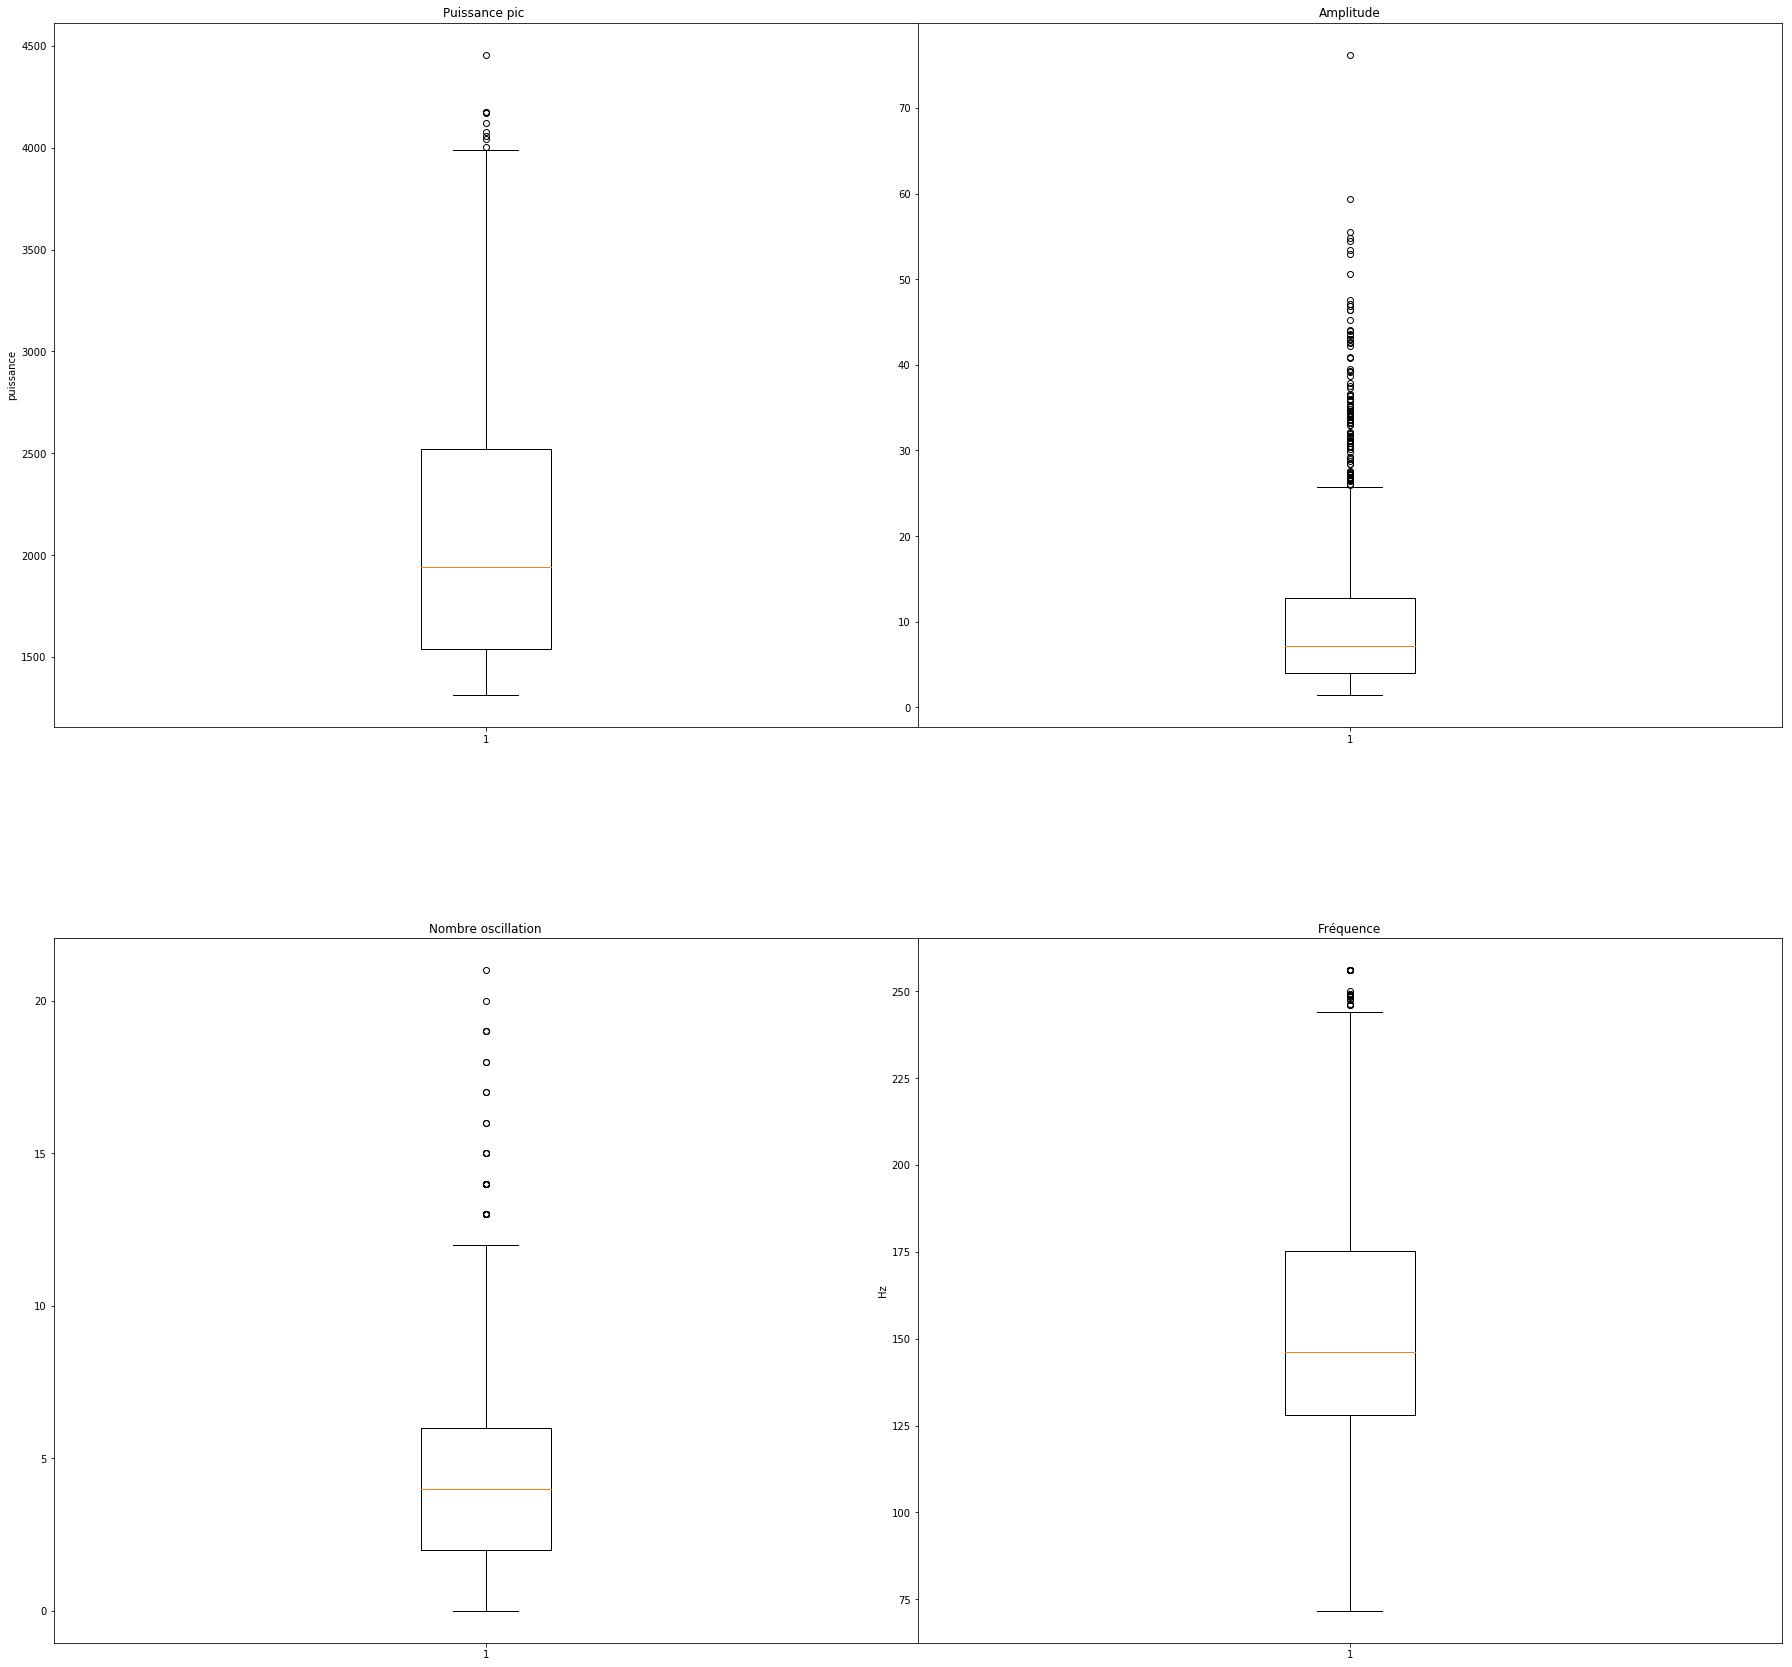

         puissance    amplitude  nombre oscillations    frequence
count  1829.000000  1829.000000          1829.000000  1829.000000
mean   2088.527387    10.013647             4.616184   152.876462
std     639.261237     8.584581             2.945582    37.974413
min    1313.363545     1.430930             0.000000    71.680000
25%    1537.285270     4.048801             2.000000   128.000000
50%    1941.453363     7.175398             4.000000   146.285714
75%    2520.378224    12.789278             6.000000   175.157895
max    4455.352983    76.200577            21.000000   256.000000


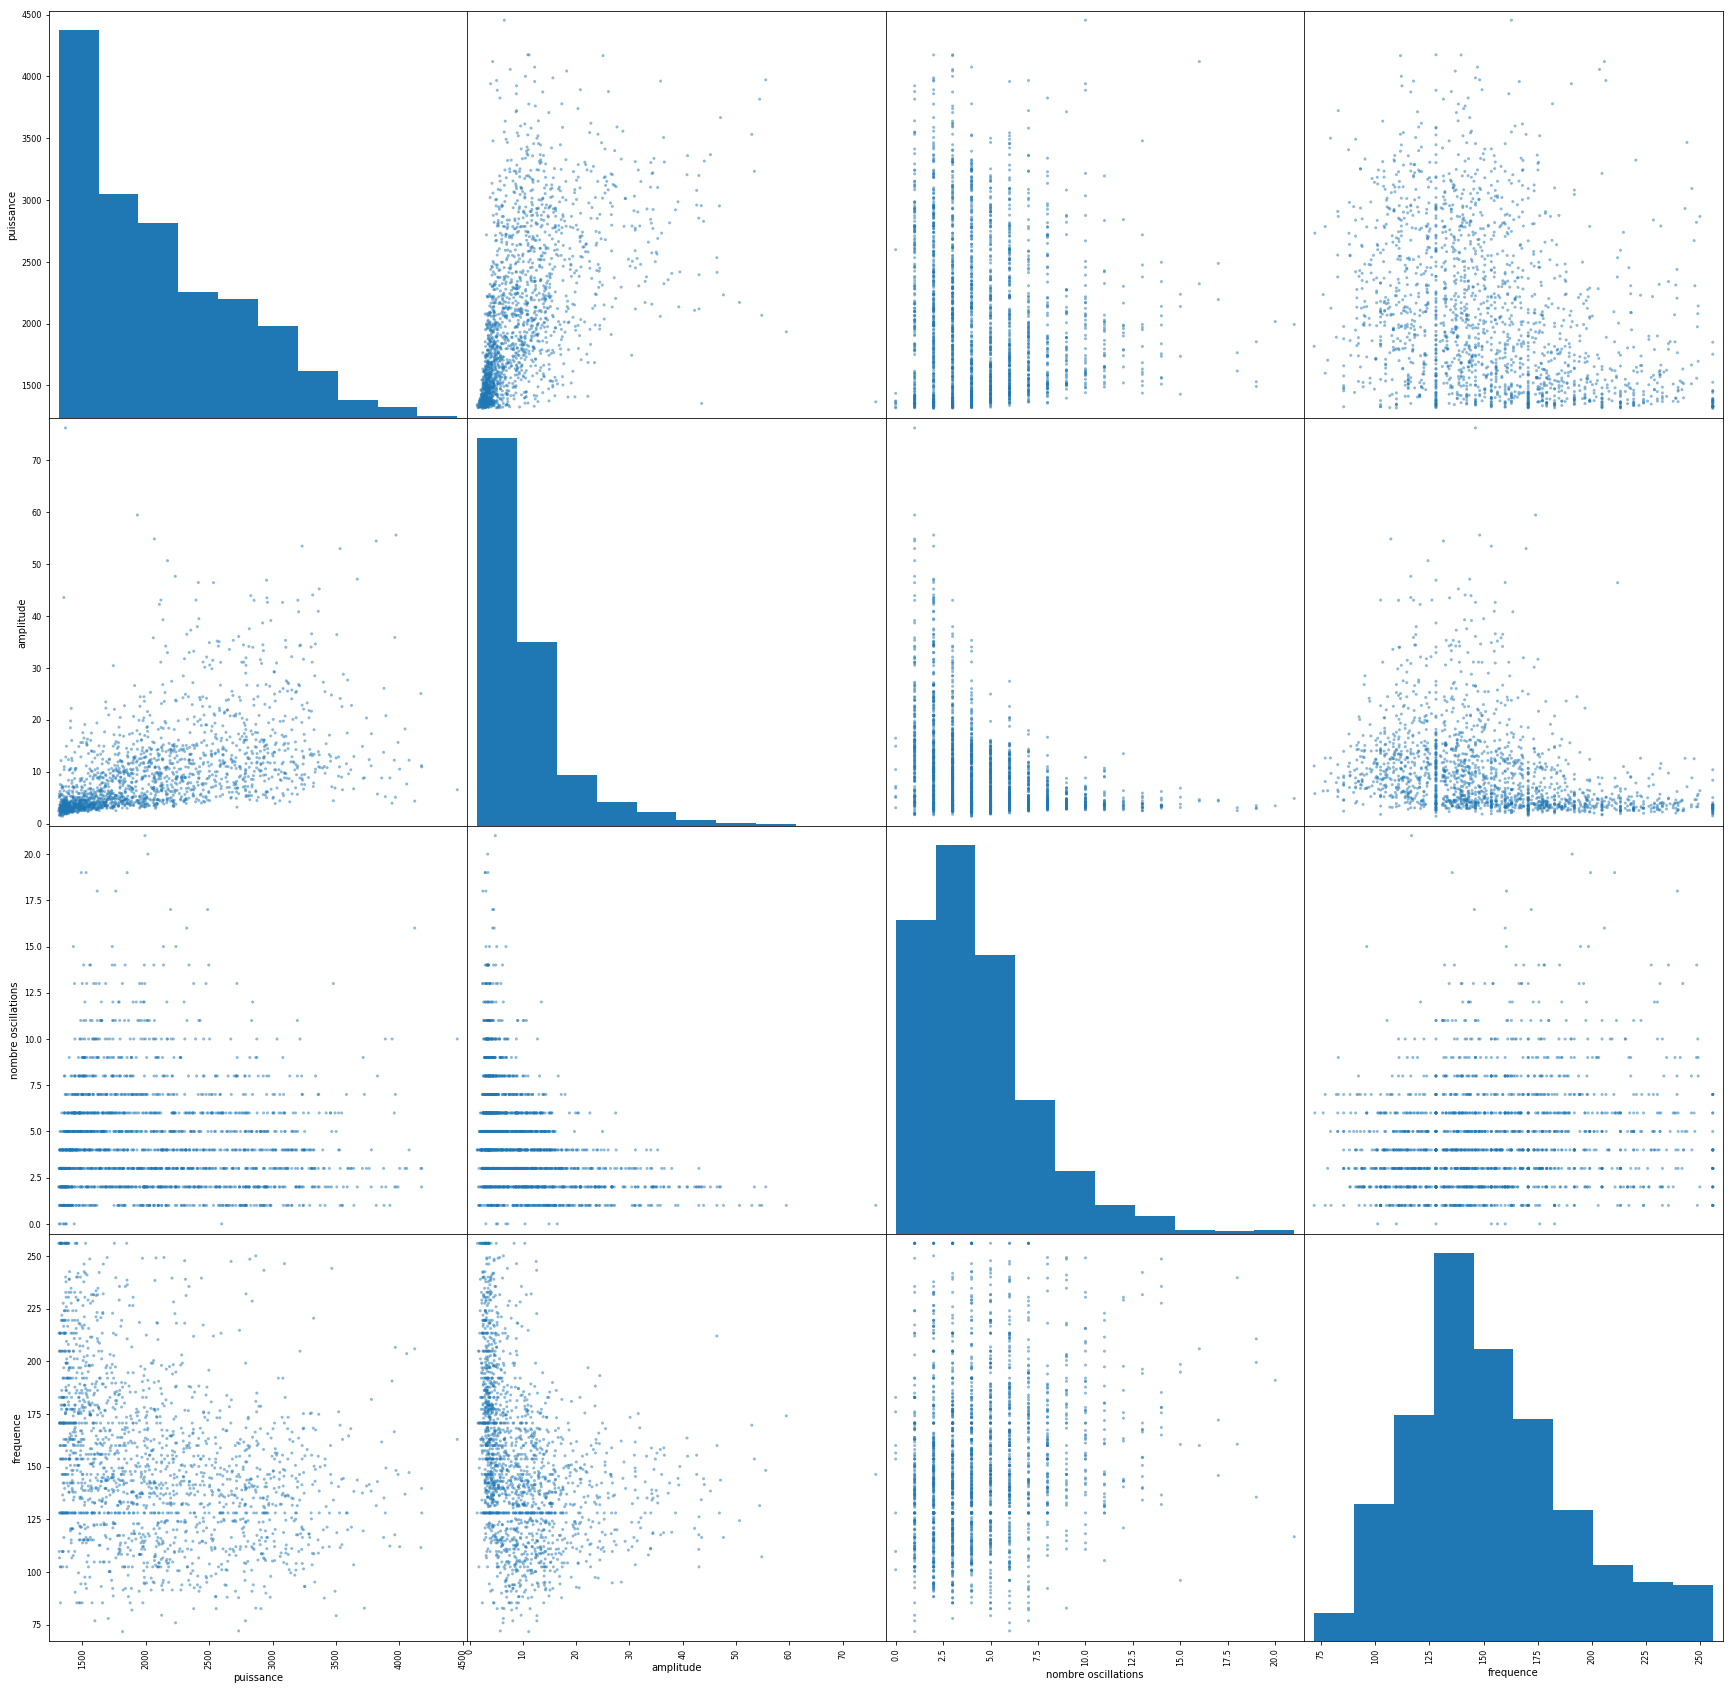

In [1]:
from extract_features import*
time=1800
T=[round(i/512,6) for i in range(1,time*512+1)]
chemin ='/Users/iris/Desktop/Projet_Rech/Exemple/EEG_58_Sig/Donnes_signaux/'
char_B =chemin+"B'2-B'1_1800s.txt"

analyse_crit(char_B,T)


Nous pouvons en déduire un dendogramme avec ces nouveaux features : 
<img src= "Dendo_new_features.png"  />

#### Classification à partir du GNG, *Normalized Cuts Criterion*

###### Définition *cut*, *normalized cut*
Etant donné deux partitions de sommets A et B d'un ensemble de sommet V tel que : $A \cup B =V$ et $ A \cap B = \emptyset $ <br/>
Etant donné une similarité $w(i,j)$, $cut(A,B)=\sum_{u \in A ,v \in B} w(u,v)$ <br/>
$Ncut(A,B)=\frac{cut(A,B)}{asso(A,V)} +\frac{cut(A,B)}{asso(B,V)}$<br/>
$asso(X,V)=\sum_{u \in X ,t \in V} w(u,t)$<br/>
Remarquons que $asso(A,V)=asso(A,A)+cut(A,B)$ 

###### cosine similarity : 
Produit scalaire normalisé : 
$K(X, Y) = \frac{<X, Y> }{||X||*||Y||}$<br/>

Il s'agit maintenant de comprendre le processus de classification à partir du Growing neural gas.
Dans un premier temps on choisit de condenser nos informations en un gaz neuronal de 100 noeuds (input de 1829 rythmes). 
On définit une varialble $W_{i,j}$ la fonction de cosine similarity entre deux features lié par une arête. On crée ainsi le graph pondéré $G(V,E,W)$. Le but de cet algorithme est de l'algorithme du normalized cut criterium est de partitionner cet arbre en différents cluster afin de maximiser la fraction des poids total au sein de chaque groupe. 
Ainsi étant donnée une partition $V$ (set de nos features), $\Gamma_V^K={V_1,V_2 ...,V_K}$ <br/>
Nous cherchons à maximiser : 
$\epsilon(\Gamma_V^K)=1/K*\sum_{l=1}^{K}\frac{\sum_{i \in V_l j \in V_l}W(i,j)}{\sum_{i \in V_l j \in V}W(i,j)}$
<br/>
Pour chaque $V_l$ de notre partition on veut que la somme des poids des vecteurs de cette partition avec le reste des partition soit minimal. On cherche à maximiser le poid des connections au sein de cette partition <br/>

En pratique on représente $(\Gamma_V^K)$ par une matrice X. Avec $X=[X_1,X_2, ... X_K]$
<br/>
$X(i,l)=1$ si $i \in V_l$, soit si le vecteur i appartient au cluster $V_l$, sinon $X(i,l)=0$<br/>
remarquons qu'il y a une condition de contrainte implicite sur X : $X1_K=1_N$ (chaque vecteur i ne peut appartenir qu'à un groupe). 
<br/> Le problème devient le suivant : 
maximiser : 
$\epsilon(\Gamma_V^K)=1/K*\sum_{l=1}^{K}\frac{X_L^TWX_l}{X_L^DWX_l}$, $X \in {0,1}^{NxK}$avec $D=diag(W1_N)$, la matrice des degrée contenant sur sa diagonal le poids total des connections de chaque vecteur features. La solution optimisée du problème ci dessus revient à système généralisé de valeur propre. 
Il s'agit du même problème que trouver la solution $(D-W)=\lambda D y $ On cherche la deuxième plus petite valeur propre qui nous séparera en deux notre graph pondéré

##### Implémentation 
Nous créeons dans un premier temps la matrice contenant les poids. A l'issus de cette construction nous déterminons la matrice D. Ensuite à l

In [4]:
import io
import sys
from ClusterGNG import *
time=1800
T=[round(i/512,6) for i in range(1,time*512+1)]
chemin ='/Users/iris/Desktop/Projet_Rech/Exemple/EEG_58_Sig/Donnes_signaux/'
char_B =chemin+"B'2-B'1_1800s.txt"
# Les données
t_max_pic_high,p_max_high,inter_pic_high,int_high,ind,A_high,sig_high,nb_oscill,freq=crit_clust(char_B,T)
data=np.array([nb_oscill,freq,p_max_high,A_high]).transpose()
#Fabrication du GNG
text_trap = io.StringIO()
sys.stdout = text_trap
neural_gas = algorithms.competitive.growing_neural_gas.GrowingNeuralGas(n_inputs=4,shuffle_data=True,verbose=True, max_edge_age=10, n_iter_before_neuron_added=50,max_nodes=100)
# On entraine

neural_gas.train(data,epochs=100)
#Le cluster avec Normalized cut criterion
# now restore stdout function
sys.stdout = sys.__stdout__
W=weight_mat(neural_gas.graph)
D=mat_D(W)
val,vect=repartition(D-W)
plot_vect(vect)
# Grâce à l'affichage on considère que 0 est bon seuil

vectA,indvectA,vectB,indvectB=bipartie(vect)
b=calc_b(vectA,vectB)
vect_rep=continue2discrete(vect,b,indvectA,indvectB)
#analyse_groupe(neural_gas.graph,indvectA,indvectB)
plot_repartition(neural_gas.graph,0,1,indvectA,indvectB)
plot3D_repartition(neural_gas.graph,0.5,2,1,0,indvectA,indvectB)

/Users/iris/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


NameError: name 'neural_gas' is not defined

### Calcul d'une corrélation

Nous cherchons dans ce projet à déterminer la communication entre deux zones du cerveau : l'hippocampe et le cortex préfrontal. Cela revient à déterminer une corrélation entre les rythmes delta observés dans le cortex préfrontal, et les rythmes spindle. 

#### STA 

Nous utilisons pour cela le spike triggerred average. Il s'agit de regarder les comprtement moyen d'une série temporelle correspondant au rythme delta au voisinnage (1024 seconde avant ou après) un pic SPW-RS. 
Après avoir trié les SPW-Rs en deux classes différentes effectue l'algorithme STA avec les deux groupes de SPW-Rs détecté. 

#### Méthode classification 1 

##### STA après

/Users/iris/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


cophenecy 0.7489625833949128
nb de pic SPW 1333


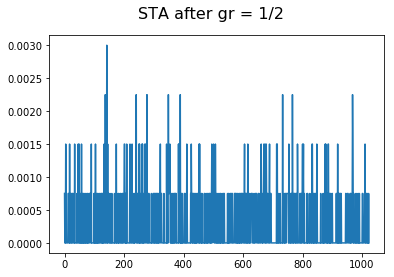

cophenecy 0.7489625833949128
nb de pic SPW 496


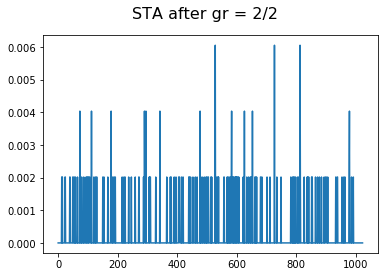

In [8]:
# STA 
plot_STA(1024,'after',2,1) # groupe 1 pour deux cluster
plot_STA(1024,'after',2,2)

##### STA avant

/Users/iris/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


cophenecy 0.7489625833949128
nb de pic SPW 1333


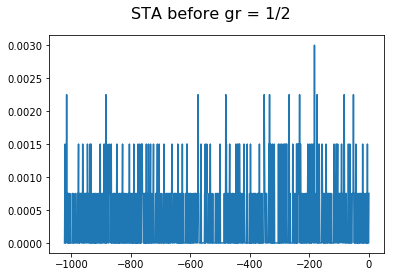

cophenecy 0.7489625833949128
nb de pic SPW 496


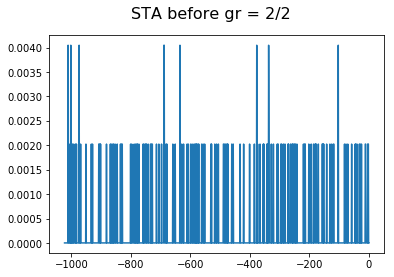

In [9]:
plot_STA(1024,'before',2,1) # groupe 1 pour deux cluster
plot_STA(1024,'before',2,2)

Même si on ne peut pas vraiment parler vraiment de cluster (pas distance assez suffisante). On remarque cependant que après les SPW du groupe deux le maximum de proba d observer un rythme delta u un instant t est plus élevé. Mais cependant c'est peut être juste lié au fait qu'il n'y a moins de SPW dans le deuxième groupe  

### Accélération du code
Nous travaillons avec des séries de 1800s afin, que le calcul de la puissance, ainsi que la détection des "pics" en delta ne soit pas refaites à chaque fois, le fichier Fast_treatment.py a été crée. Il contient les fonctions qui transorme nos données en fichier texte et les fonctions qui transformes ces fichiers textes en vecteur. 
